In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(cowplot)
library(ggrepel)
library(ggbeeswarm)
library(patchwork)
library(RColorBrewer)
library(pheatmap)
library(broom)
})
theme_set(theme_cowplot())
options(repr.plot.width=15,repr.plot.height=9, width=150)

# Crinacle IEMs Ranking

# data preprocessing

In [2]:
# data downloaded from the site on 2023-11-17
a <- read_csv("crinacle.csv", col_types='', name_repair = 'universal')

# group signatures into fewer categories
a <- mutate(a, sig_group=case_when(
    grepl("Balanced", Signature) ~ "Neutral",
    Signature == "Mid-centric" ~ "Neutral",
    Signature == "Bassy" ~ "Warm",
    grepl("Dark", Signature) ~ "Warm",
    grepl("Warm", Signature) ~ "Warm",
    grepl("Bright", Signature) ~ "Bright",
    grepl("failure", Signature) ~ "Unique",
    Signature == "Variable" ~ "Unique",
    Signature == "W-shaped" ~ "Unique",
    grepl("U-shape", Signature) ~ "U-shaped",
    grepl("V-shape", Signature) ~ "V-shaped",
    grepl("Neutral with", Signature) ~ "Neutral",
    TRUE ~ Signature
))

rank_levels <- c(
    'N/A', 'DQ', 'F', 'E', 
    'D-', 'D', 'D+',
    'C-', 'C', 'C+',
    'B-', 'B', 'B+',
    'A-', 'A', 'A+',
    'S-', 'S', 'S+'
)

# transform ranks into ordered factors
a <- mutate(a, 
    Rank=ordered(Rank, levels=rank_levels),
    Technical.Grade=ordered(Technical.Grade, levels=rank_levels),
    Tone.Grade=ordered(Tone.Grade, levels=rank_levels),
    Value.Rating=ordered(replace_na(Value.Rating, ''), levels=c('', '★','★★','★★★'))
)

a <- mutate(a,
    # extract brand from model
    brand=str_extract(Model, '^\\S+'),
    # number of total drivers
    n_drivers=unlist(map(str_split(Setup, ' '), ~ sum(as.numeric(replace_na(str_extract(.x, '\\d+'), "1"))))),
    # number of distict drivers
    n_setup=lengths(str_split(Setup, ' ')),
    # group setup into fewer categories
    setup_group=case_when(
        grepl("^\\d+DD$", Setup) ~ "DD",
        grepl("^\\d+BA$", gsub("\\/","",Setup)) ~ "BA",
        grepl("\\?|MS|Piezo|BC|Exciter|AMT", Setup) ~ "Others",
        Setup == 'Electrostatic' ~ 'EST',
        n_setup == 2 ~ "Hybrid",
        n_setup == 3 ~ 'Tribrid',
        TRUE ~ Setup
    )
)

# rename some columns
a <- rename(a,
    Price_MSRP=Pricesort
)

# remove discontinued/free stuff
a <- filter(a, Price_MSRP>0, Price_MSRP<99999)

New names:
• `Value Rating` -> `Value.Rating`
• `Price (MSRP)` -> `Price..MSRP.`
• `Tone Grade` -> `Tone.Grade`
• `Technical Grade` -> `Technical.Grade`


In [3]:
head(a)

Rank,Value.Rating,Model,Price..MSRP.,Signature,Comments,Tone.Grade,Technical.Grade,Setup,Status,Ranksort,Tonesort,Techsort,Price_MSRP,sig_group,brand,n_drivers,n_setup,setup_group
<ord>,<ord>,<chr>,<chr>,<chr>,<chr>,<ord>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>
S-,★★,"Hidition Viento(B-mode, custom)",950,Variable,Best-in-class tuning and tonal balance with near-perfect coherency. Recommended as a custom-fit.,S+,A+,4BA,Zeppelin & Co demo unit,14,1,13,950,Unique,Hidition,4,1,BA
S-,★★,ThieAudio Monarch Mk2,1000,Neutral with bass boost,NA,S+,A+,2EST 6BA 1DD,Available for demo at The Hangout,14,1,13,1000,Neutral,ThieAudio,9,3,Tribrid
A+,★,Hidition NT6,1050,Neutral,"If Etymotic made a multi-BA IEM, this would be the closest to that dream",S-,A+,6BA,Null Audio demo unit,20,7,13,1050,Neutral,Hidition,6,1,BA
A+,★,ThieAudio V16 Divinity,1500,Neutral with bass boost,NA,S-,A+,16BA,Available for demo at The Hangout,20,7,13,1500,Neutral,ThieAudio,16,1,BA
A+,★,Sony IER-Z1R,1700,Mild V-shape,"Extended yet natural treble, realistic sub-bass focus and spacious imaging capabilities.",A+,S-,1BA 2DD,Personal unit,20,13,7,1700,V-shaped,Sony,3,2,Hybrid
A+,★★★,Moondrop Variations,520,U-shaped,Sub-bass-focused signature with Moondrop's clean tuning makes this one of the best $500 tribrids.,S,A,2EST 2BA 1DD,Available for demo at The Hangout,24,3,21,520,U-shaped,Moondrop,5,3,Tribrid


# Grade Correlations

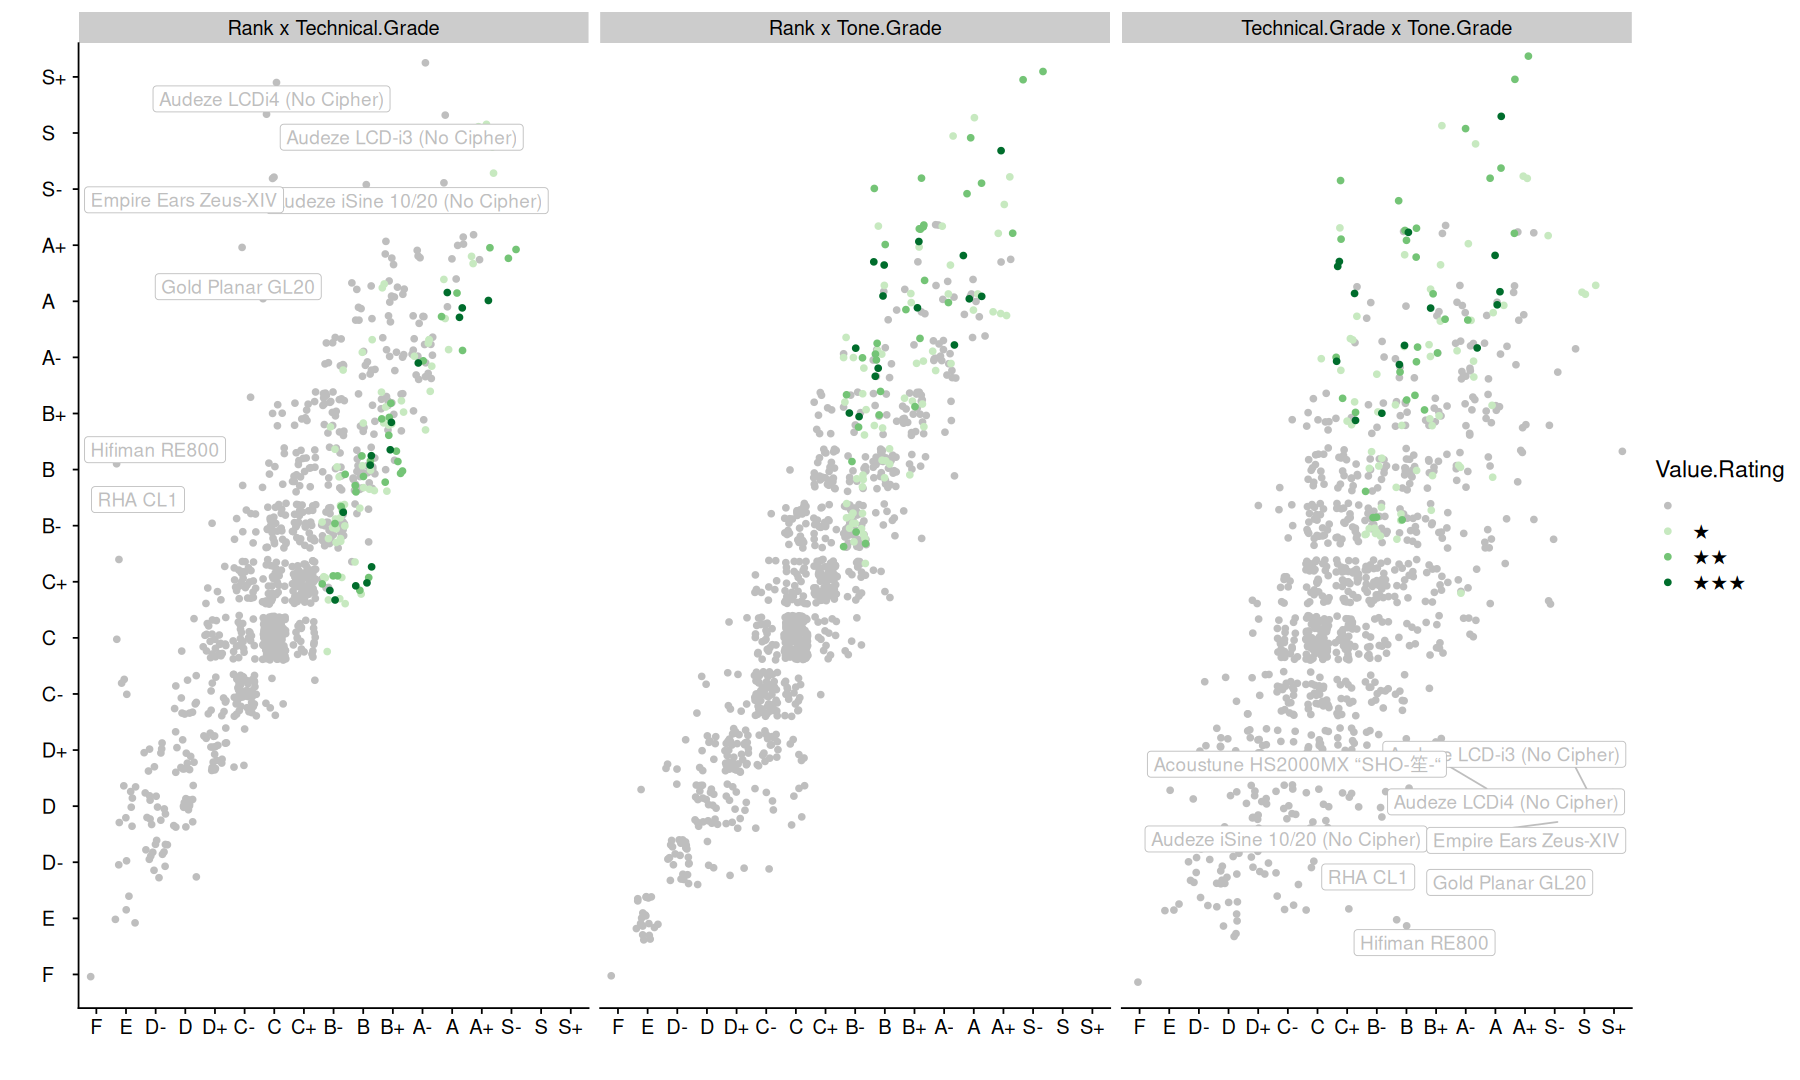

In [4]:
select(a, Model, Rank, Technical.Grade, Tone.Grade, Value.Rating) |>
pivot_longer(names_to = 'k', values_to = 'v', -c(Model, Value.Rating)) %>%
inner_join(eval(.), by=c('Model', 'Value.Rating'), relationship = "many-to-many") |>
filter(k.x<k.y) |>
mutate(l=paste(k.x, 'x',k.y)) |>
mutate(v=abs(as.numeric(v.x)-as.numeric(v.y))) |>
arrange(Value.Rating) -> b
ggplot(b, aes(x=v.x, y=v.y, color=Value.Rating)) + 
scale_color_manual(values=c('gray','#c7e9c0','#74c476','#006d2c')) +
geom_jitter() + 
facet_wrap(~l) +
labs(x='', y='') +
theme(axis.text.y=element_text(hjust=0)) +
geom_label_repel(data=filter(b, v>7), aes(label=Model), size=4, position=position_jitter(), show.legend = FALSE)

the table includes 3 different grades: Technical, Tone, and overall Rank.

as we can see in the plots, the grades correlate very well with each other, with the exception of a few models labeled in the graph.

with this in mind, in the following analyses, I will focus just on the overall ranking.

# Rank distribution

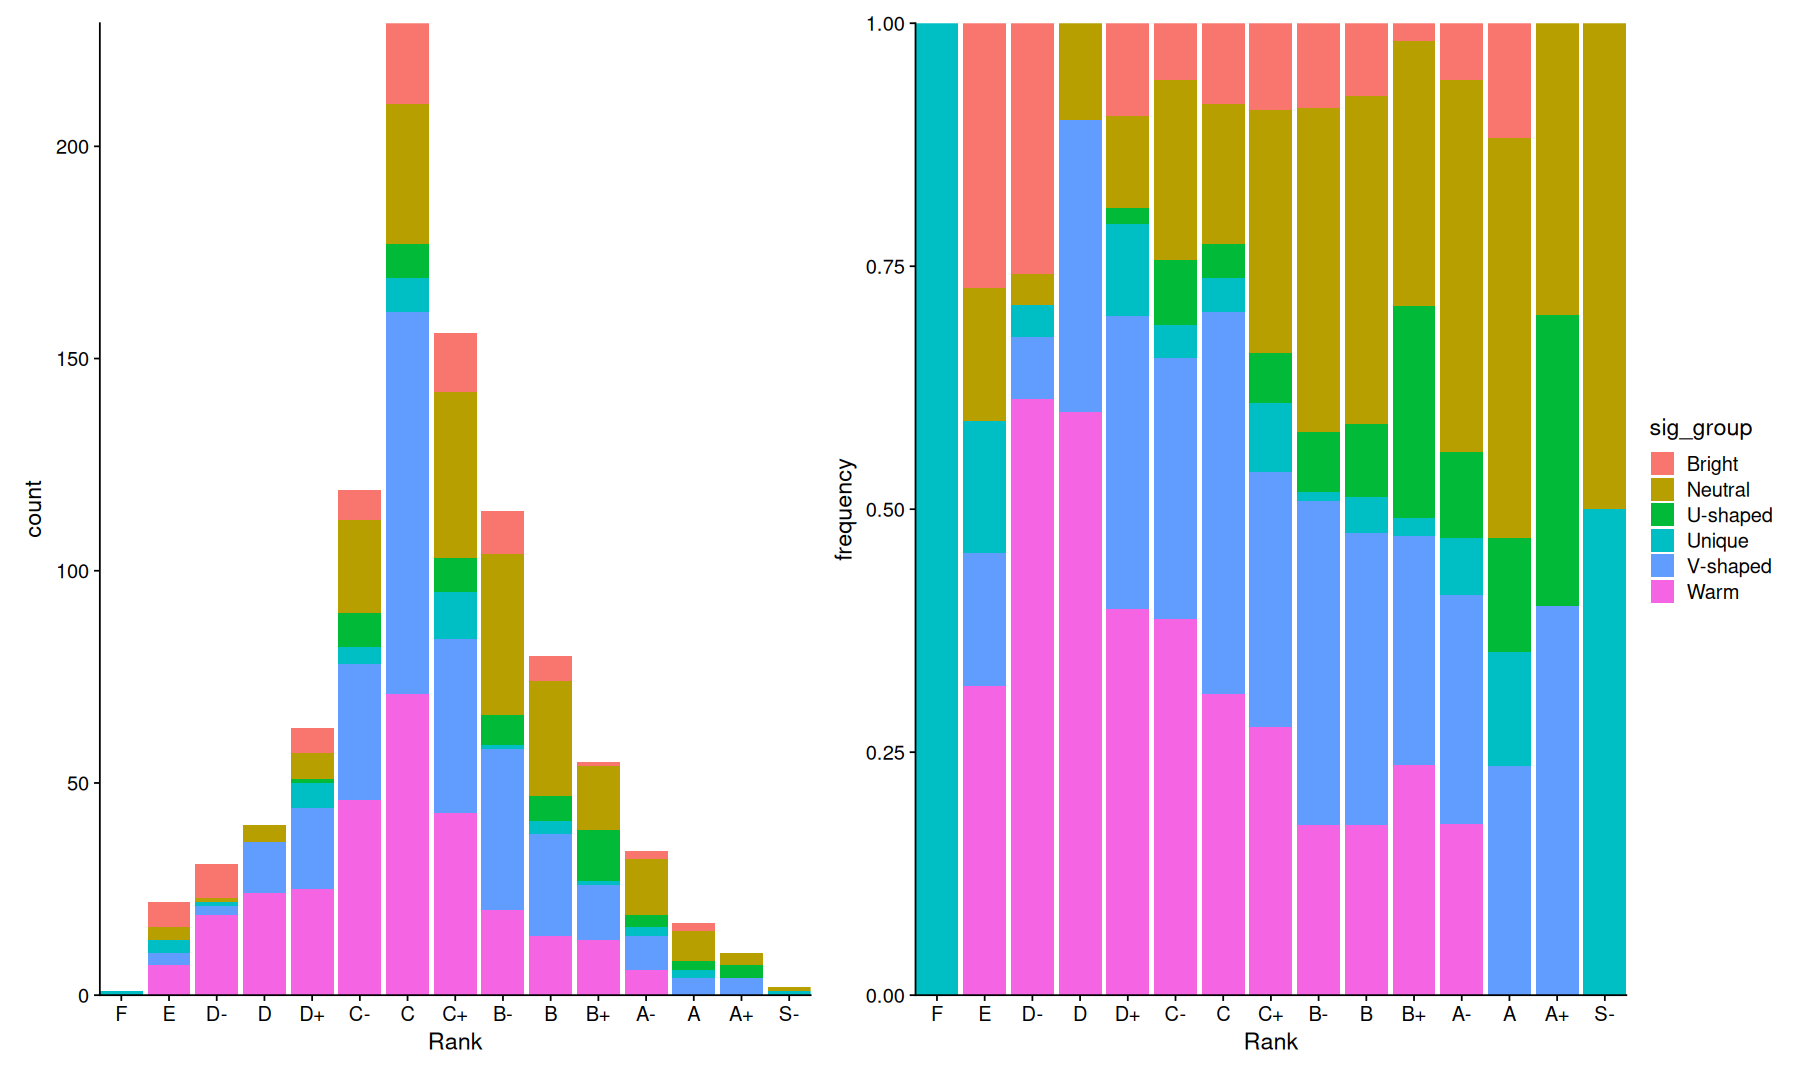

In [5]:
p1 <- ggplot(a, aes(x=Rank, fill=sig_group)) + geom_bar() + coord_cartesian(expand=0)
p2 <- ggplot(a, aes(x=Rank, fill=sig_group)) + geom_bar(position='fill') + labs(y='frequency') + coord_cartesian(expand=0)
p1 + p2 + plot_layout(guides='collect')

on the left we can see the total amount of headphones by rank, we see a somewhat normally-shaped distribution, with C-Ranks as the most common headphones in the table.

on the right we see the relative frequency of sound signatures by rank, 
note how warm signatures are frequent at the lower ranks but go down in frequency, while neutral, V-shaped and "unique" signatures dominate the higher ranks.

# Price distribution

Orientation inferred to be along y-axis; override with `position_quasirandom(orientation = 'x')`


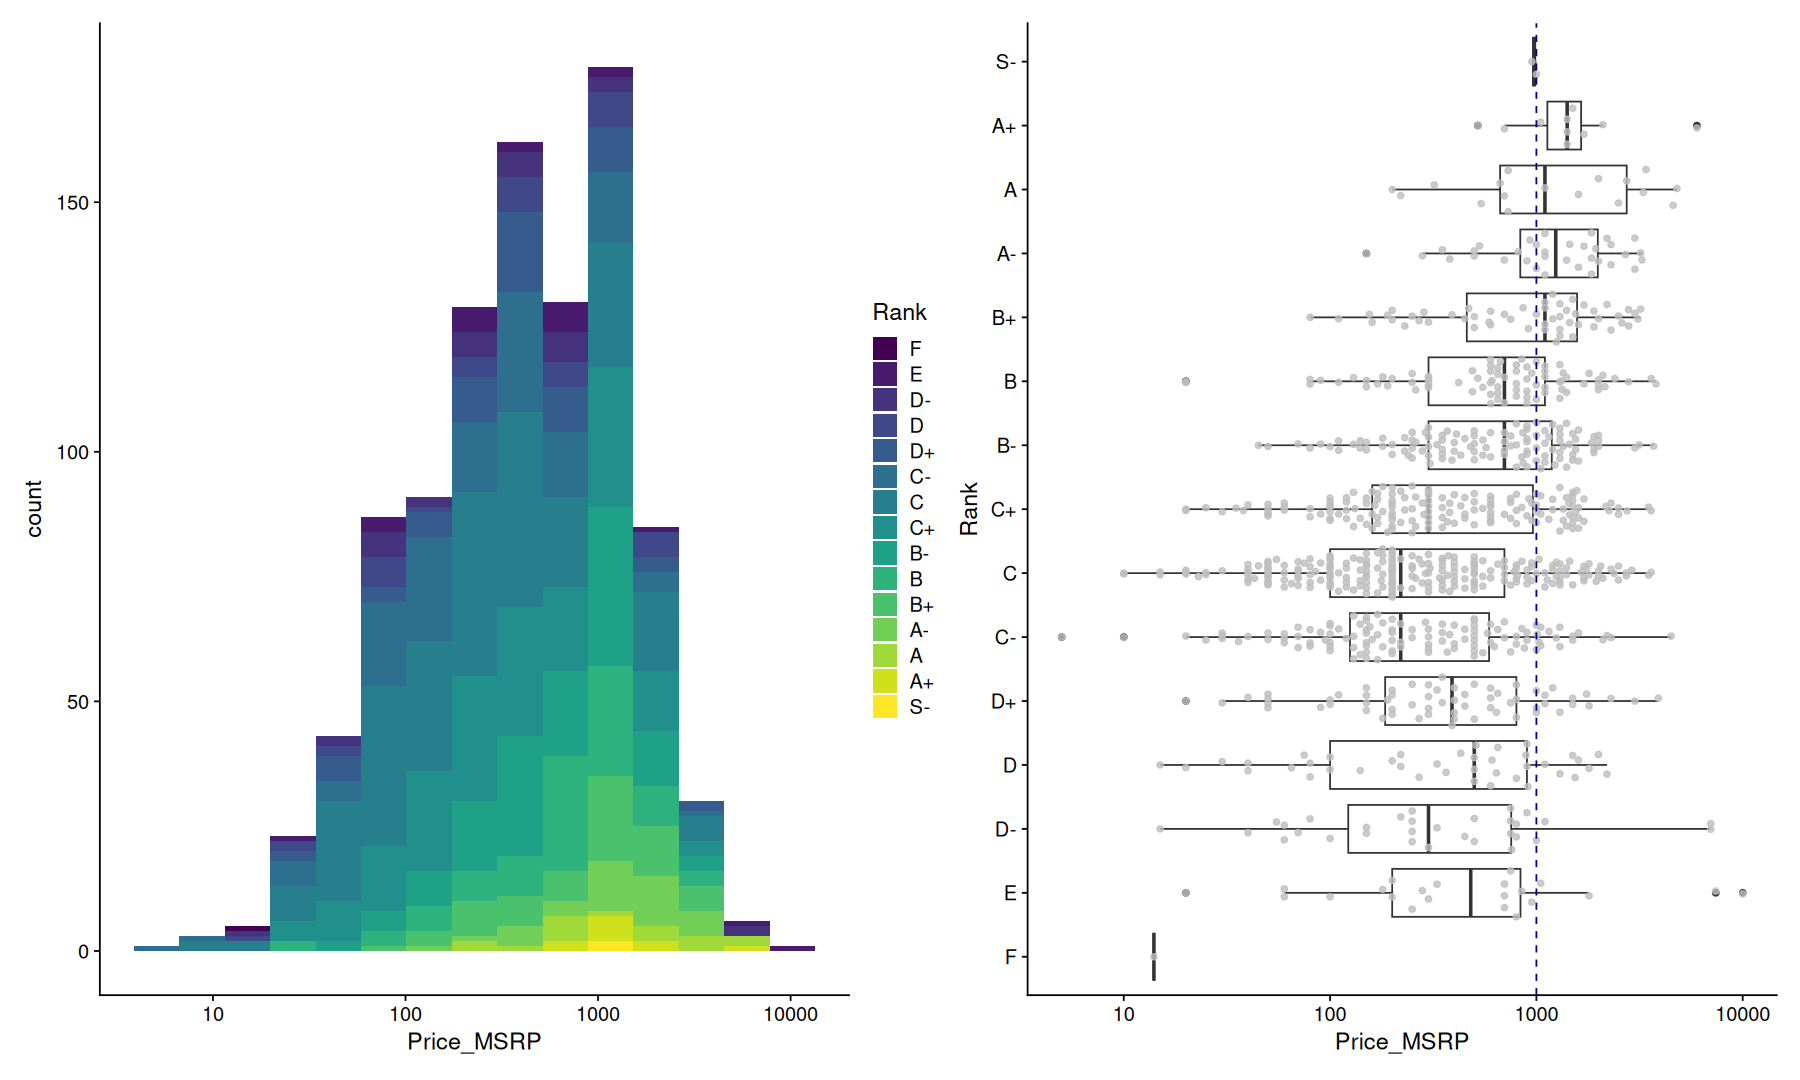

In [6]:
p1 <- ggplot(a, aes(x=Price_MSRP, fill=Rank)) + 
geom_histogram(bins = 15) + 
scale_x_log10()

p2 <- ggplot(a, aes(y=Rank, x=Price_MSRP)) + 
geom_boxplot() + 
scale_x_log10() + 
geom_quasirandom(alpha=0.8, color='gray') +
geom_vline(xintercept=1000, linetype=2, color='darkblue')

p1 + p2

on the left, we can see the overall price distribution of all headphones, 
note that the x-axes here are log-scaled, we can see headphones for as low as 5 and as high as 10k, but most headphones, are priced around 100~1000.

on the right, we can see the price breakdown by rank,
note how even though there is a tendency for higher-ranked headphones to be more expensive you shouldn't have to spend more than 1k to have the best-sounding headphones.

There still is a lot of variation even among headphones of the same rank,
as an example, let's look at the price variation of rank B headphones:

In [7]:
filter(a, Rank=='B') |> with(summary(Price_MSRP))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20     300     700     896    1100    3800 

even though the median price is 700, you can find headphones at this rank for as low as 20 and as high as 3800 !!

obviously, there is more to the price than just sound, but since this dataset only grades the sonic performance,
a natural question that follows is: what is the best price for performance that we can get?

# Price x Rank

Orientation inferred to be along y-axis; override with `position_quasirandom(orientation = 'x')`
Orientation inferred to be along y-axis; override with `position_quasirandom(orientation = 'x')`


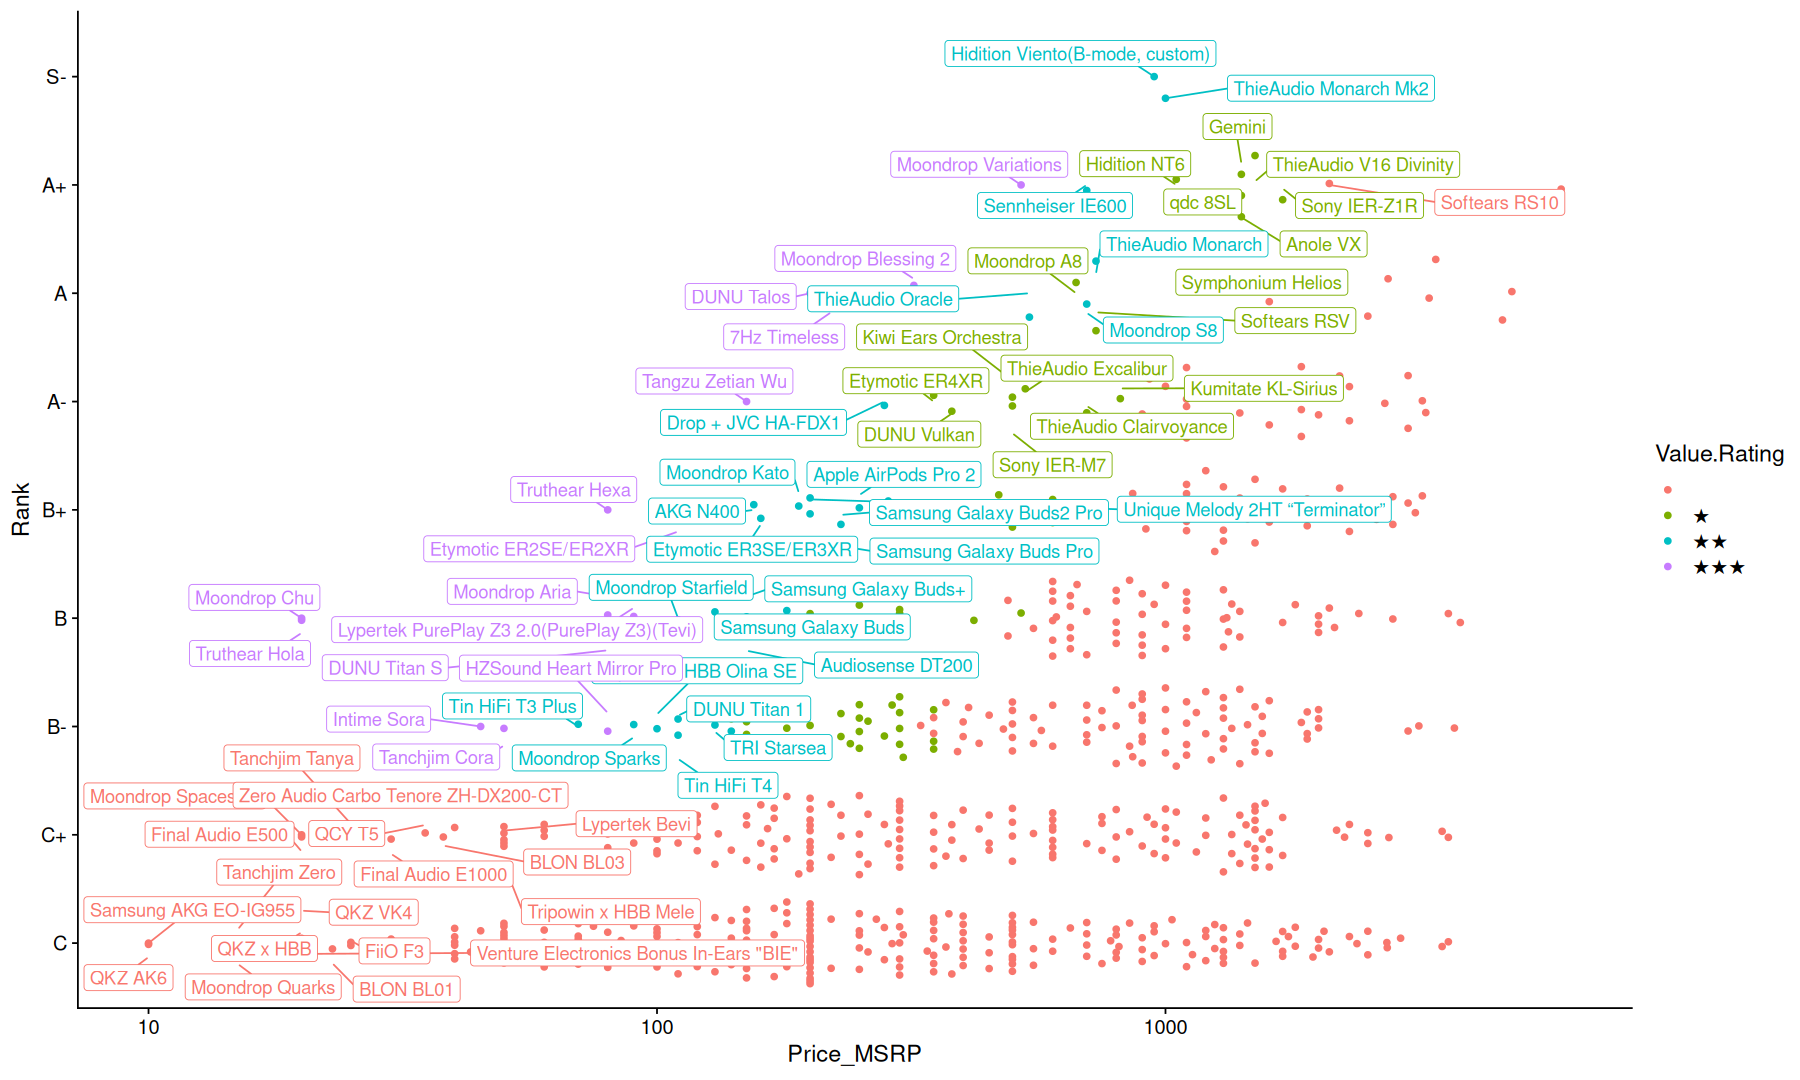

In [8]:
b <- 
    arrange(a, Price_MSRP) |>
    group_by(Rank) |> 
    mutate(pr=row_number()) |> 
    ungroup() |>
    filter(Rank>="C")

ggplot(b, aes(y=Rank, x=Price_MSRP, color=Value.Rating)) + 
geom_quasirandom() + 
scale_color_hue() +
geom_label_repel(data=filter(b, pr<10), aes(label=Model), min.segment.length = 0, max.overlaps = 20, position = position_quasirandom(), show.legend = FALSE) + 
scale_x_log10()

here we have a scatter plot of the Rank x Price, 
I only included C-Rank and above because I think if you only care about sound performance there is nothing worth the money below this rank.

the top 10 cheapest headphones of each rank are labeled in the graph, and the colors indicate the "Value Rating" from the dataset.

# What about TWS ?

In [9]:
filter(b, grepl("Sams|Appl", Model)|grepl("TWS",Comments), pr<10, Price_MSRP>10)

Rank,Value.Rating,Model,Price..MSRP.,Signature,Comments,Tone.Grade,Technical.Grade,Setup,Status,Ranksort,Tonesort,Techsort,Price_MSRP,sig_group,brand,n_drivers,n_setup,setup_group,pr
<ord>,<ord>,<chr>,<chr>,<chr>,<chr>,<ord>,<ord>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>,<int>
B,★★★,Lypertek PurePlay Z3 2.0(PurePlay Z3)(Tevi),90,Neutral with bass boost,Probably the closest thing to an ER2XR in TWS form.,A,C+,DD,Jaben Melbourne demo unit,112,21,91,90,Neutral,Lypertek,1,1,DD,5
B,★★,Samsung Galaxy Buds,130,Neutral,A surprisingly well-tuned TWS with the technical chops to boot.,A-,B,DD,Personal unit,88,31,57,130,Neutral,Samsung,1,1,DD,7
B,★★,Samsung Galaxy Buds+,150,U-shaped,Tuned even closer to the Harman IE target compared to the original.,B+,B,2DD,Personal unit,100,43,57,150,U-shaped,Samsung,2,1,DD,8
B+,★★,Samsung Galaxy Buds Pro,200,Warm V-shape,"More lower mids than your average Harman-tuned IEM, but works in its favour by being more pleasant.",A+,B,2DD,Available for demo at The Hangout,70,13,57,200,Warm,Samsung,2,1,DD,6
B+,★★,Samsung Galaxy Buds2 Pro,230,U-shaped,A less shouty interpretation of Harman with the same controlled yet impactful bass response.,S-,B,2DD,Available for demo at The Hangout,64,7,57,230,U-shaped,Samsung,2,1,DD,8
B+,★★,Apple AirPods Pro 2,250,Mild V-shape,"A more exciting sound signature in comparison to its predecessor, with little in terms of drawbacks.",A+,B,DD,Available for demo at The Hangout,70,13,57,250,V-shaped,Apple,1,1,DD,9


Interestingly, some wireless buds make it into the top 10, it's not the best you can get for the money but it's up there which I found notable.

# Brands

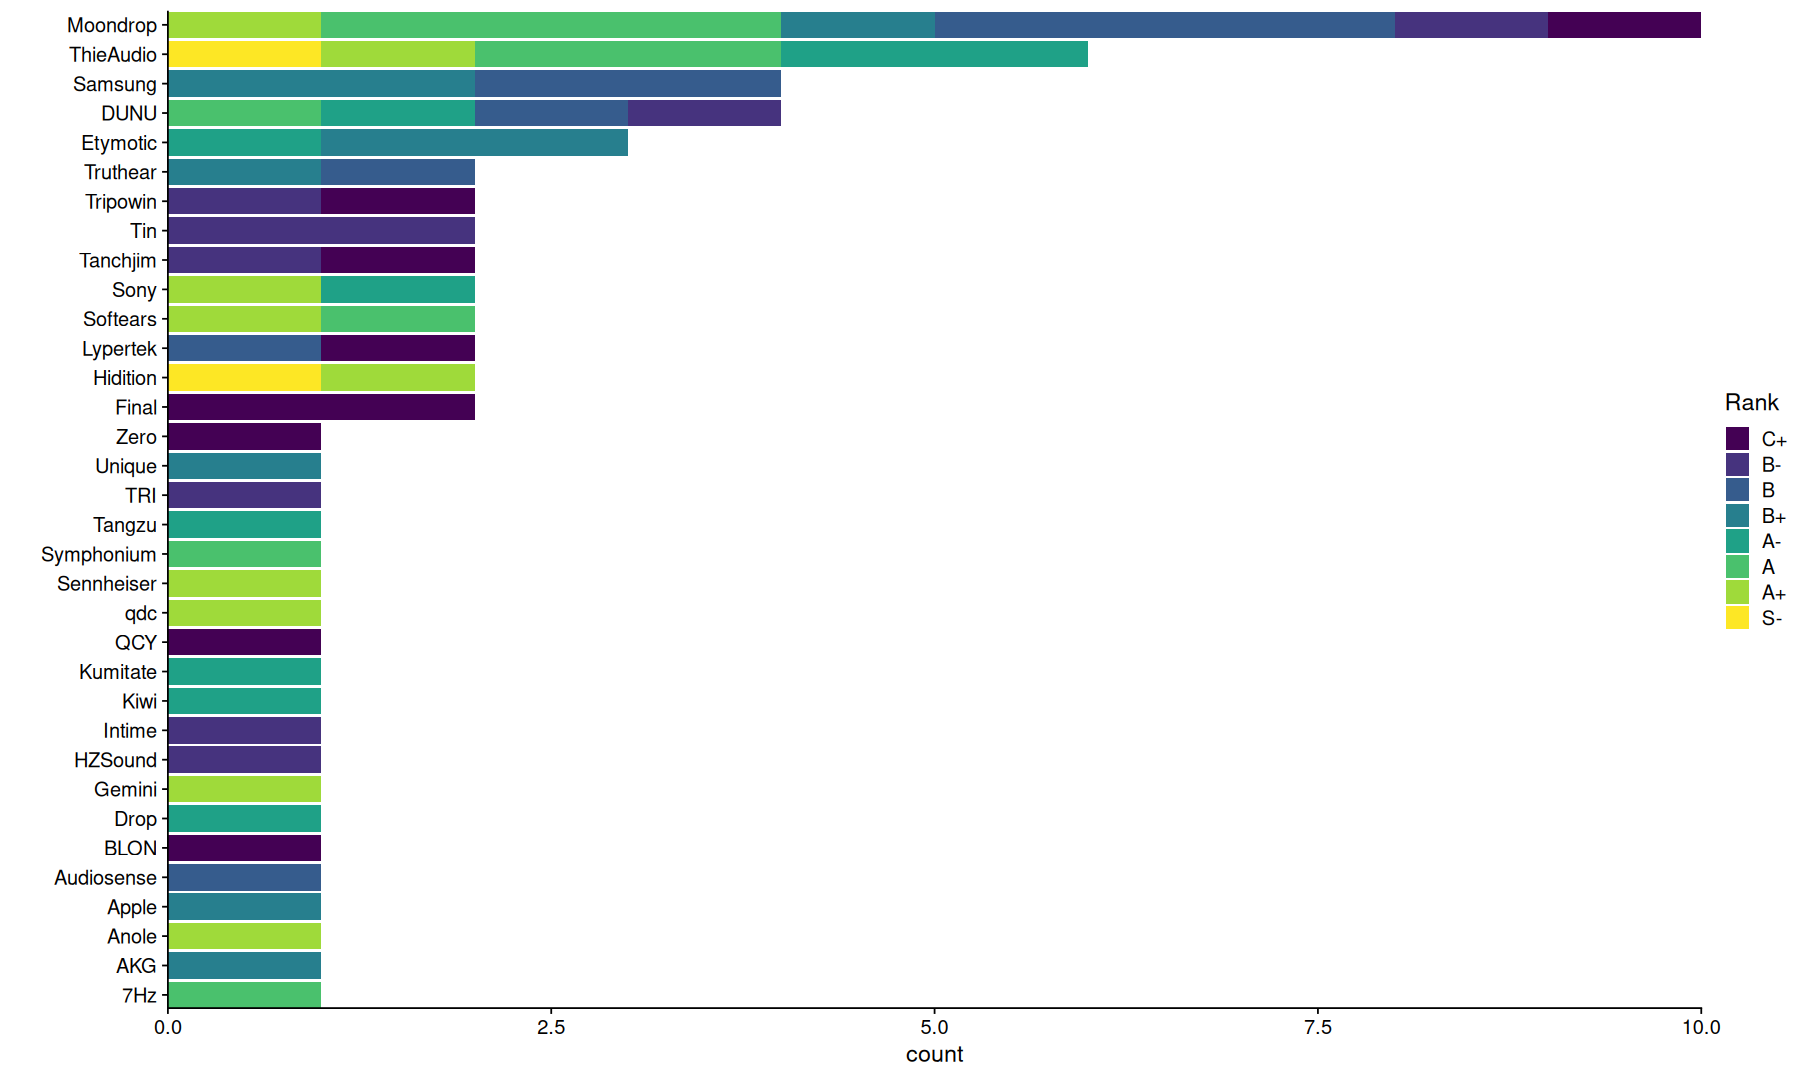

In [10]:
filter(b, Rank>"C", pr<10) |>
add_count(brand, name='total') |>
ggplot(aes(y=fct_reorder(brand, total), fill=Rank)) +
geom_bar(position='stack') +
labs(y="") +
coord_cartesian(expand=0)

if we group these selected top 10s by brand, we see that Moondrop appears 11 times across the ranks C and above, followed by ThieAudio.

# Setup

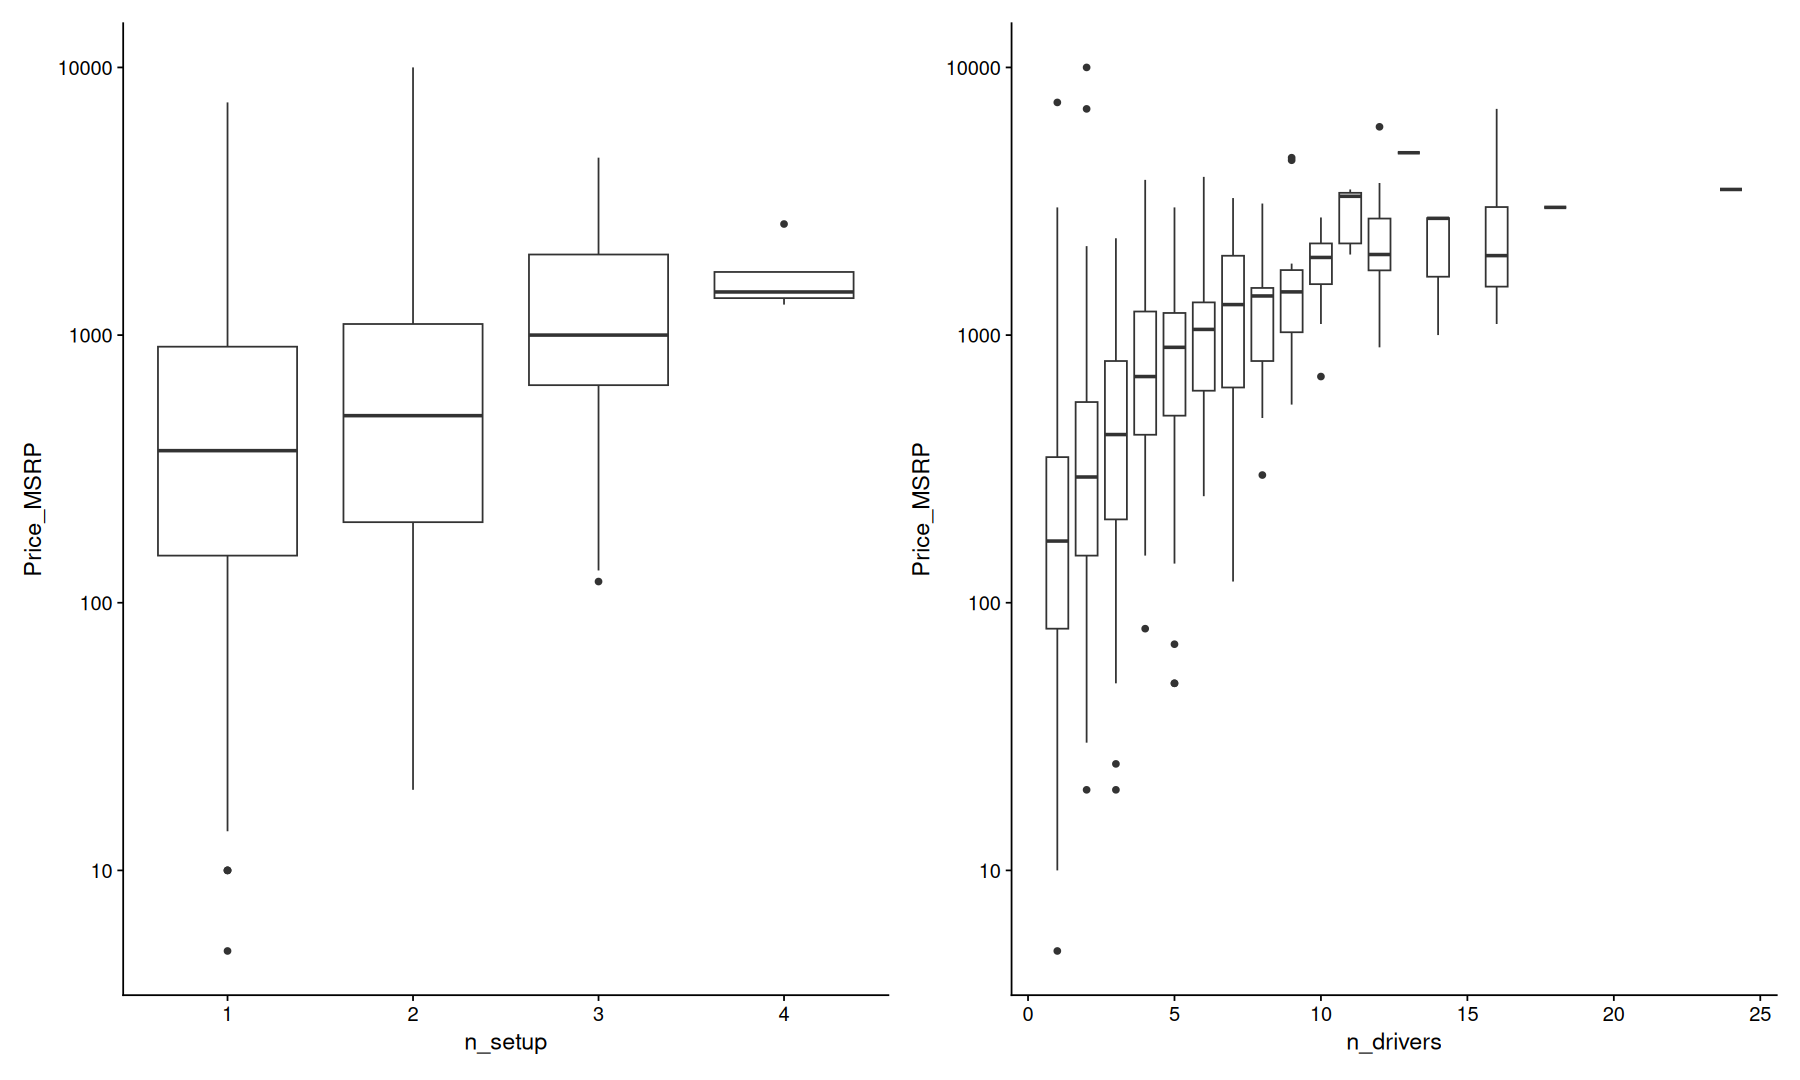

In [11]:
p1 <- ggplot(a, aes(x=n_setup, y=Price_MSRP, group=n_setup)) + 
geom_boxplot() + 
scale_y_log10()

p2 <- ggplot(a, aes(x=n_drivers, y=Price_MSRP)) + geom_boxplot(aes(group=n_drivers)) + scale_y_log10()

p1+p2

there is a clear correlation between the total number of drivers, drivers setup, and the price, as expected.

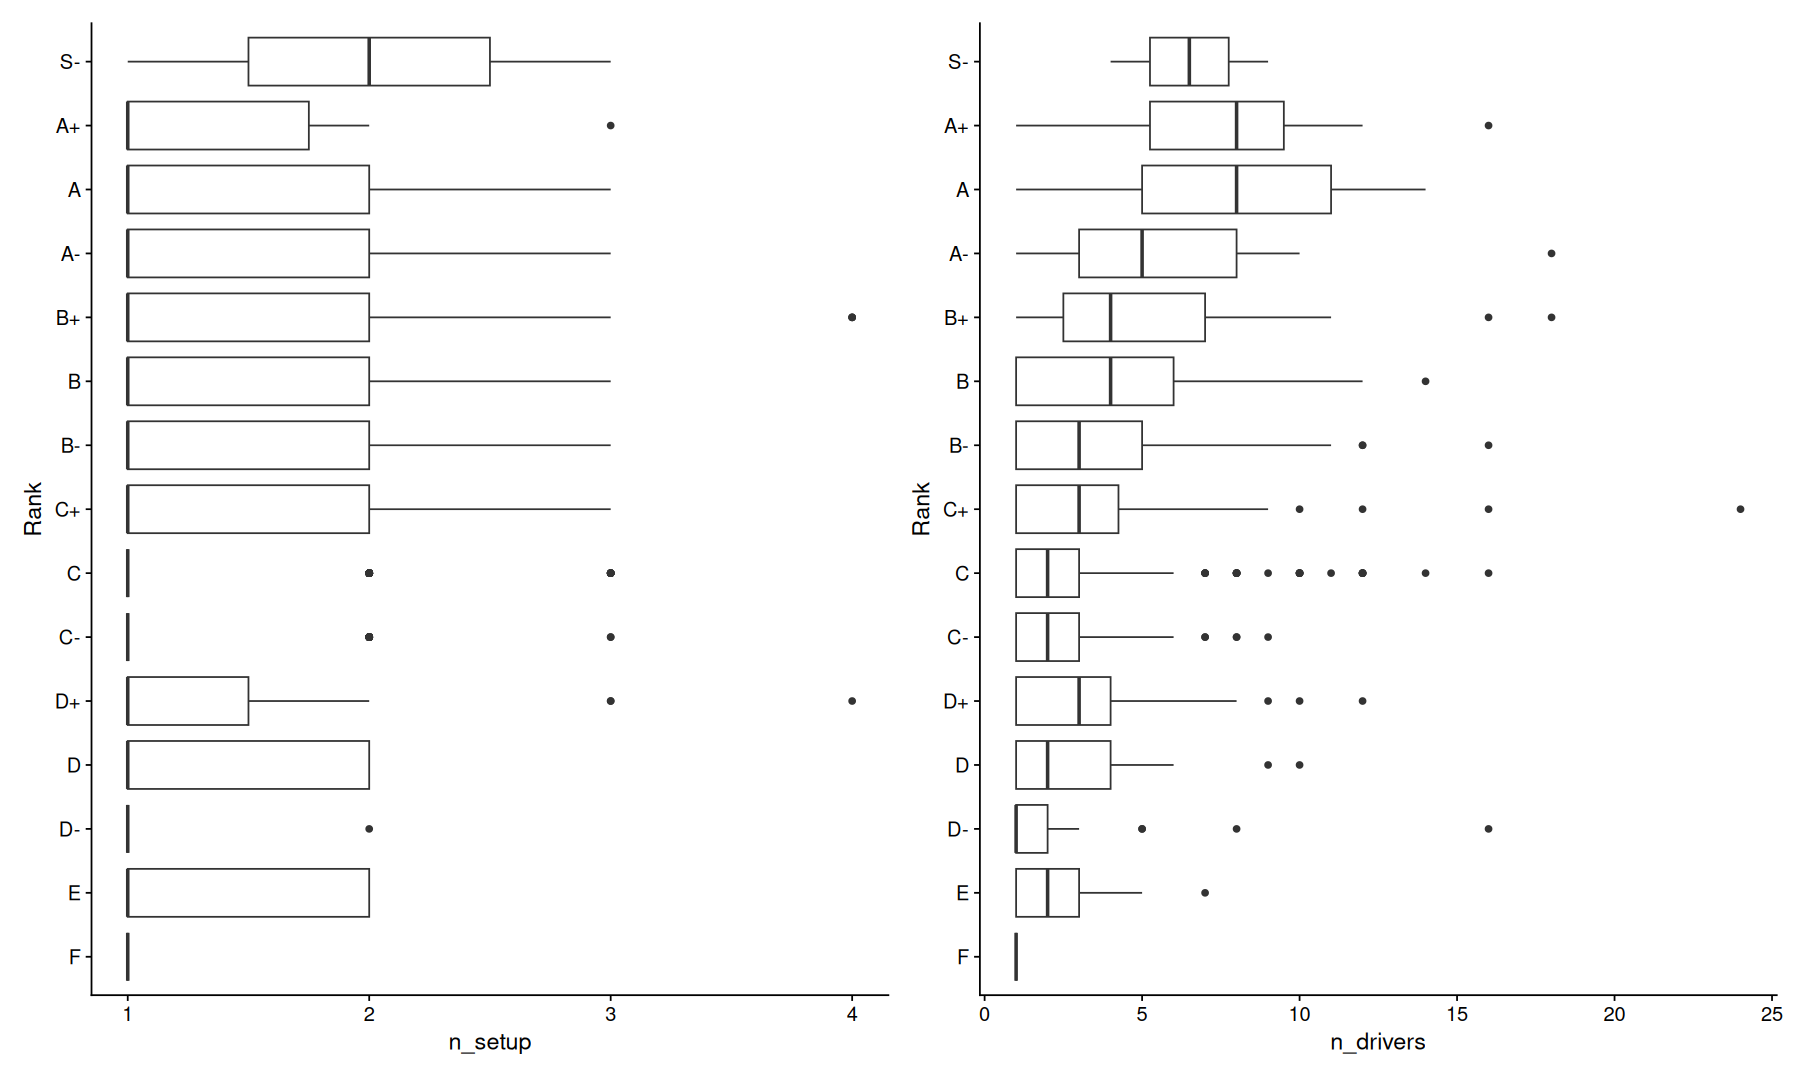

In [12]:
p1 <- ggplot(a, aes(x=n_setup, y=Rank)) + geom_boxplot()
p2 <- ggplot(a, aes(x=n_drivers, y=Rank)) + geom_boxplot()

p1+p2

more drivers do not necessarily mean better sound, although highly ranked headphones tend to have more drivers.

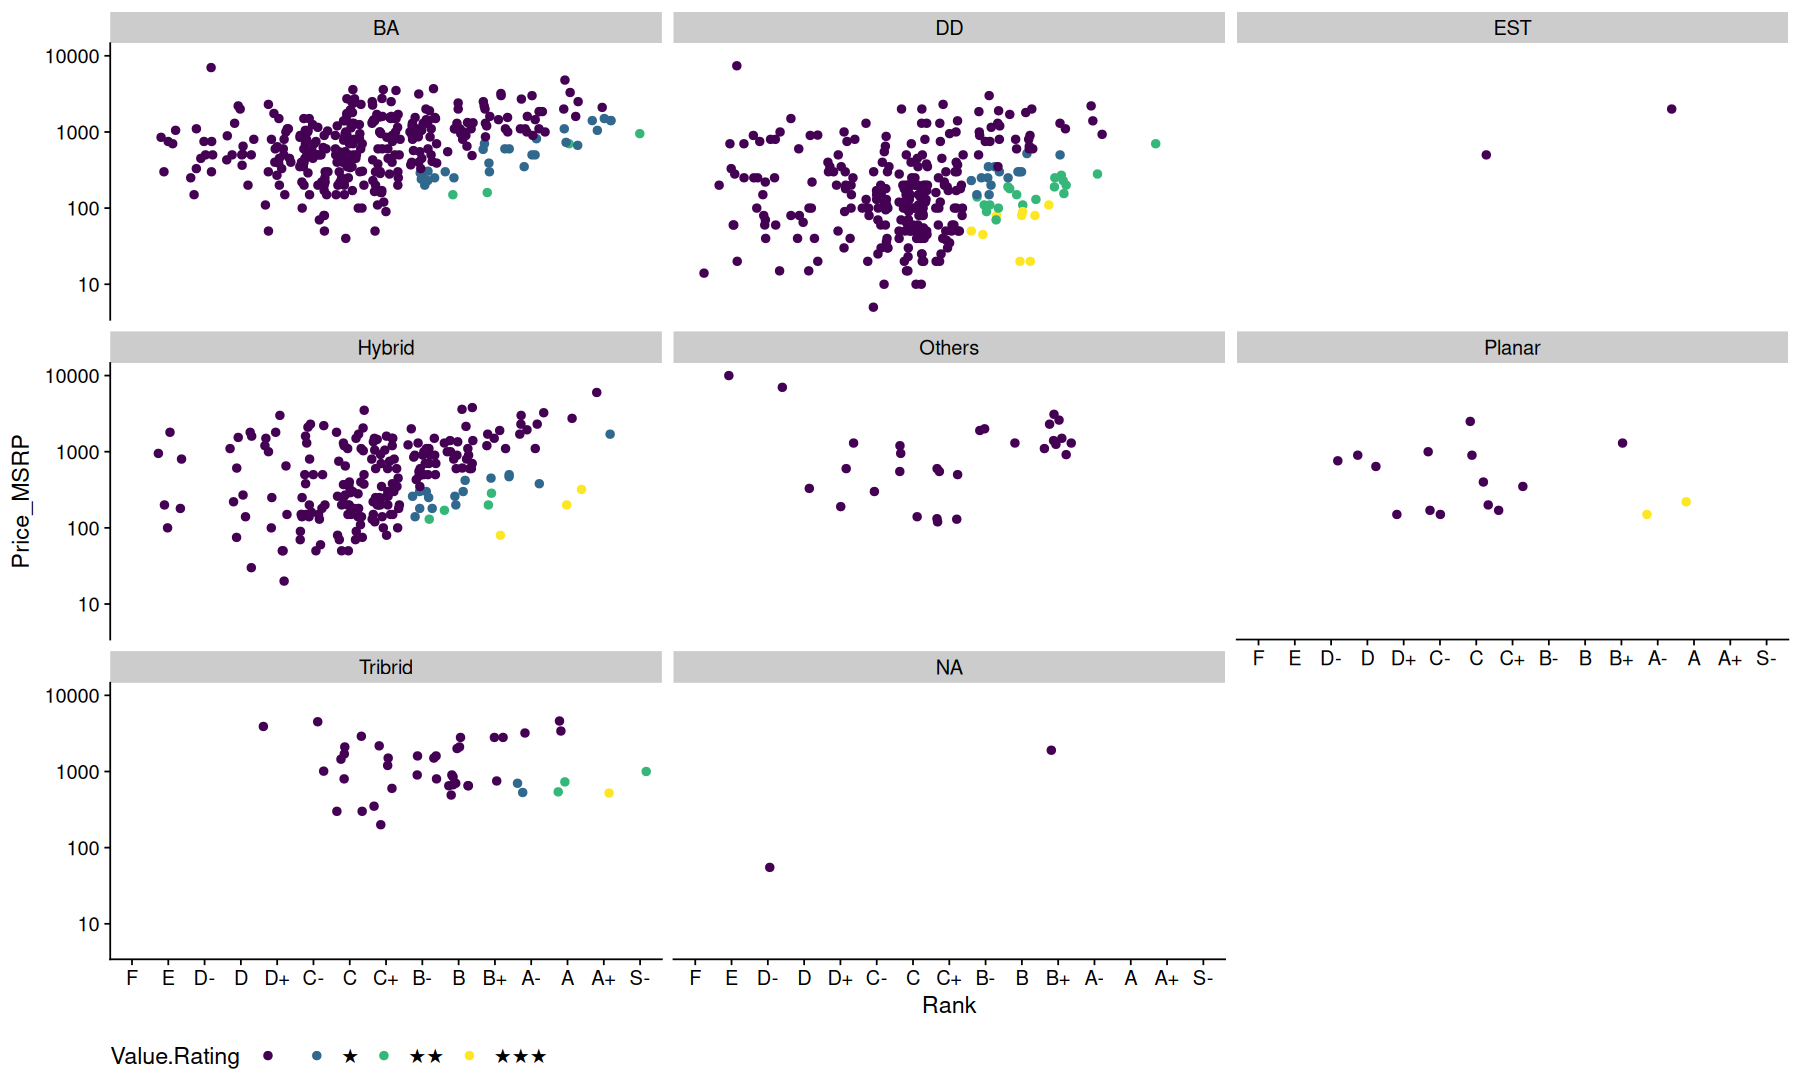

In [13]:
ggplot(a, aes(x=Rank, y=Price_MSRP, color=Value.Rating)) + 
geom_jitter(size=2) +
facet_wrap(~setup_group) +
scale_y_log10() +
theme(legend.position='bottom')

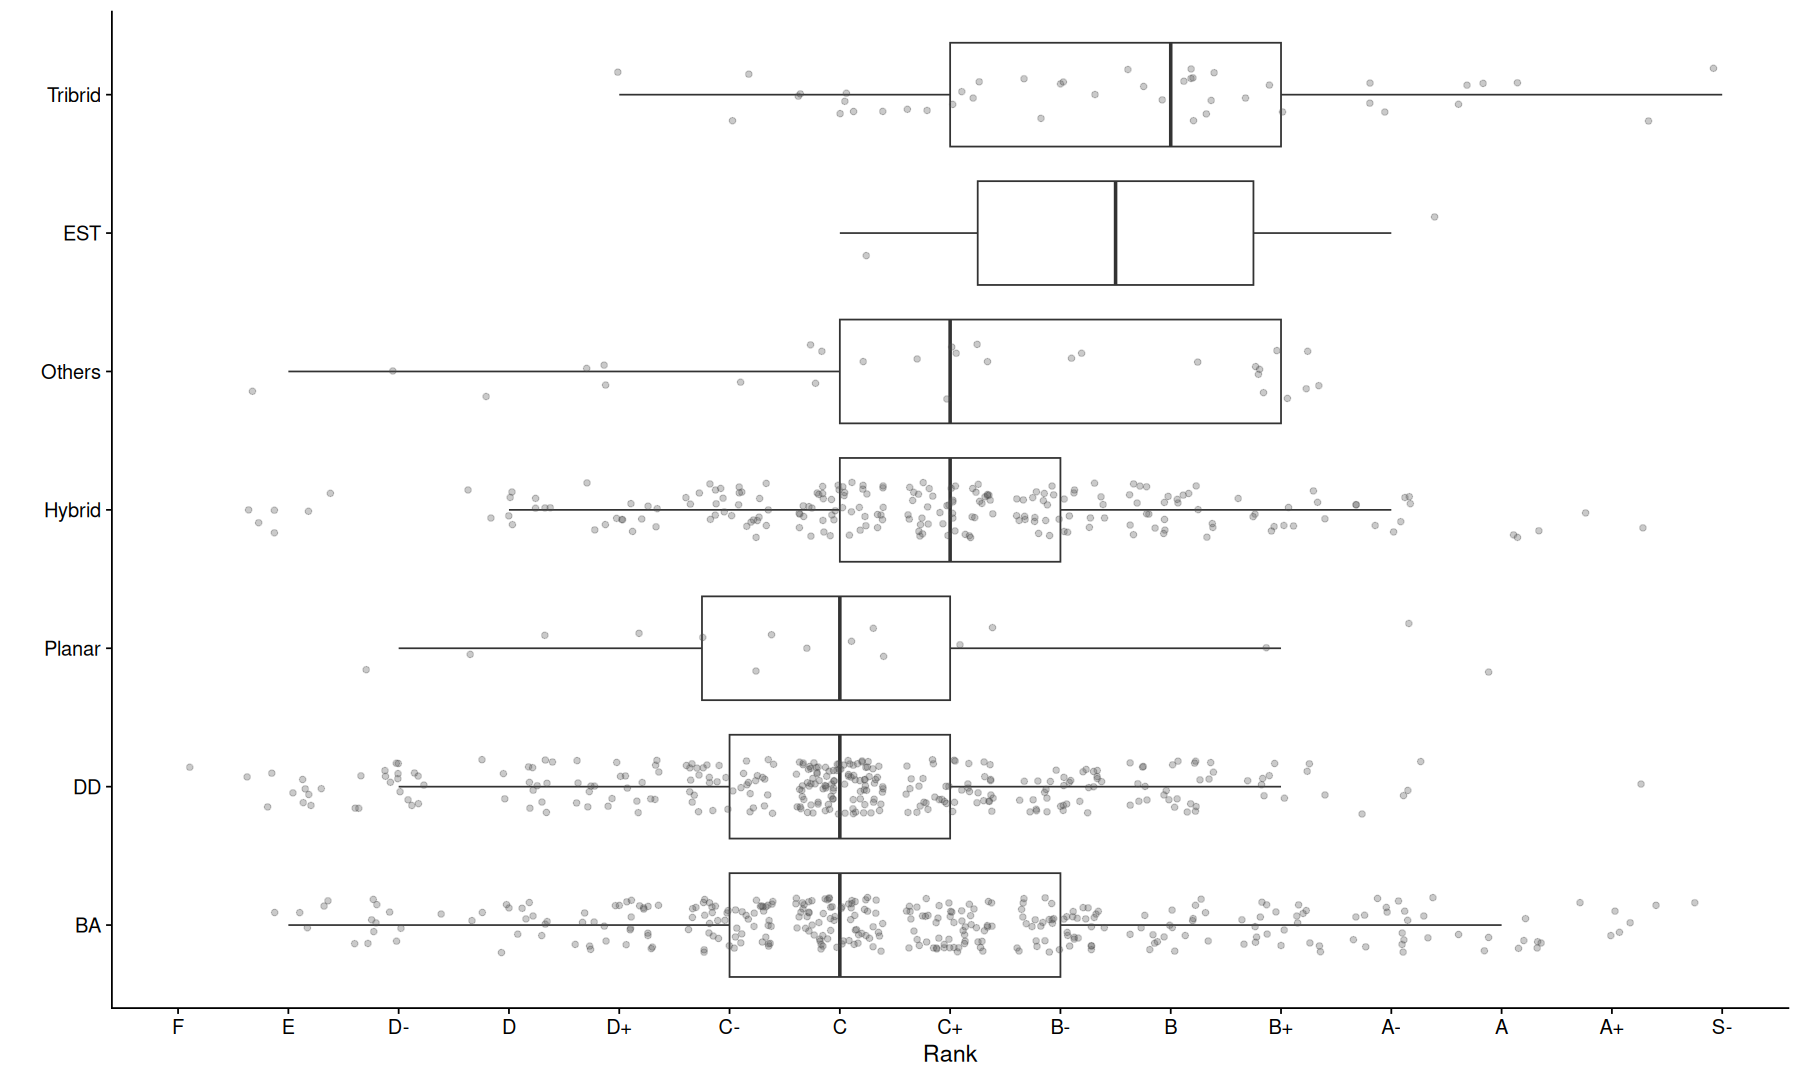

In [14]:
filter(a, !is.na(setup_group)) |>
ggplot(aes(x=Rank, y=fct_reorder(setup_group,as.numeric(Rank)), group=setup_group)) + 
geom_boxplot(outlier.shape = NA) +
geom_jitter(height=0.2,color='gray30',alpha=0.3) +
labs(y="")

# Regression model for Rank

In [15]:
mutate(a, 
       n_DD=as.numeric(ifelse(grepl("DD", Setup), replace_na(str_extract(Setup, '(\\d+)DD', group=1), "1"), 0)),
       n_BA=as.numeric(ifelse(grepl("BA", Setup), replace_na(str_extract(Setup, '(\\d+)BA', group=1), "1"), 0)),
       n_EST=as.numeric(ifelse(grepl("EST|Electrostatic", Setup), replace_na(str_extract(Setup, '(\\d+)EST', group=1), "1"), 0)),
       n_planar=as.numeric(ifelse(grepl("Planar", Setup), replace_na(str_extract(Setup, '(\\d+)Planar', group=1), "1"), 0))
) |>
glm(as.numeric(Rank) ~ log(Price_MSRP) + n_drivers + n_setup + n_planar + n_DD + n_EST + n_BA + sig_group + setup_group, data=_, family = 'gaussian') -> m
summary(m)


Call:
glm(formula = as.numeric(Rank) ~ log(Price_MSRP) + n_drivers + 
    n_setup + n_planar + n_DD + n_EST + n_BA + sig_group + setup_group, 
    family = "gaussian", data = mutate(a, n_DD = as.numeric(ifelse(grepl("DD", 
        Setup), replace_na(str_extract(Setup, "(\\d+)DD", group = 1), 
        "1"), 0)), n_BA = as.numeric(ifelse(grepl("BA", Setup), 
        replace_na(str_extract(Setup, "(\\d+)BA", group = 1), 
            "1"), 0)), n_EST = as.numeric(ifelse(grepl("EST|Electrostatic", 
        Setup), replace_na(str_extract(Setup, "(\\d+)EST", group = 1), 
        "1"), 0)), n_planar = as.numeric(ifelse(grepl("Planar", 
        Setup), replace_na(str_extract(Setup, "(\\d+)Planar", 
        group = 1), "1"), 0))))

Coefficients:
                           Estimate       Std. Error  t value   Pr(>|t|)    
(Intercept)         5.0388646194512  0.7059948937889  7.13725 1.8868e-12 ***
log(Price_MSRP)     0.3876471381845  0.0702759023098  5.51607 4.4671e-08 ***
n_drivers          -2.

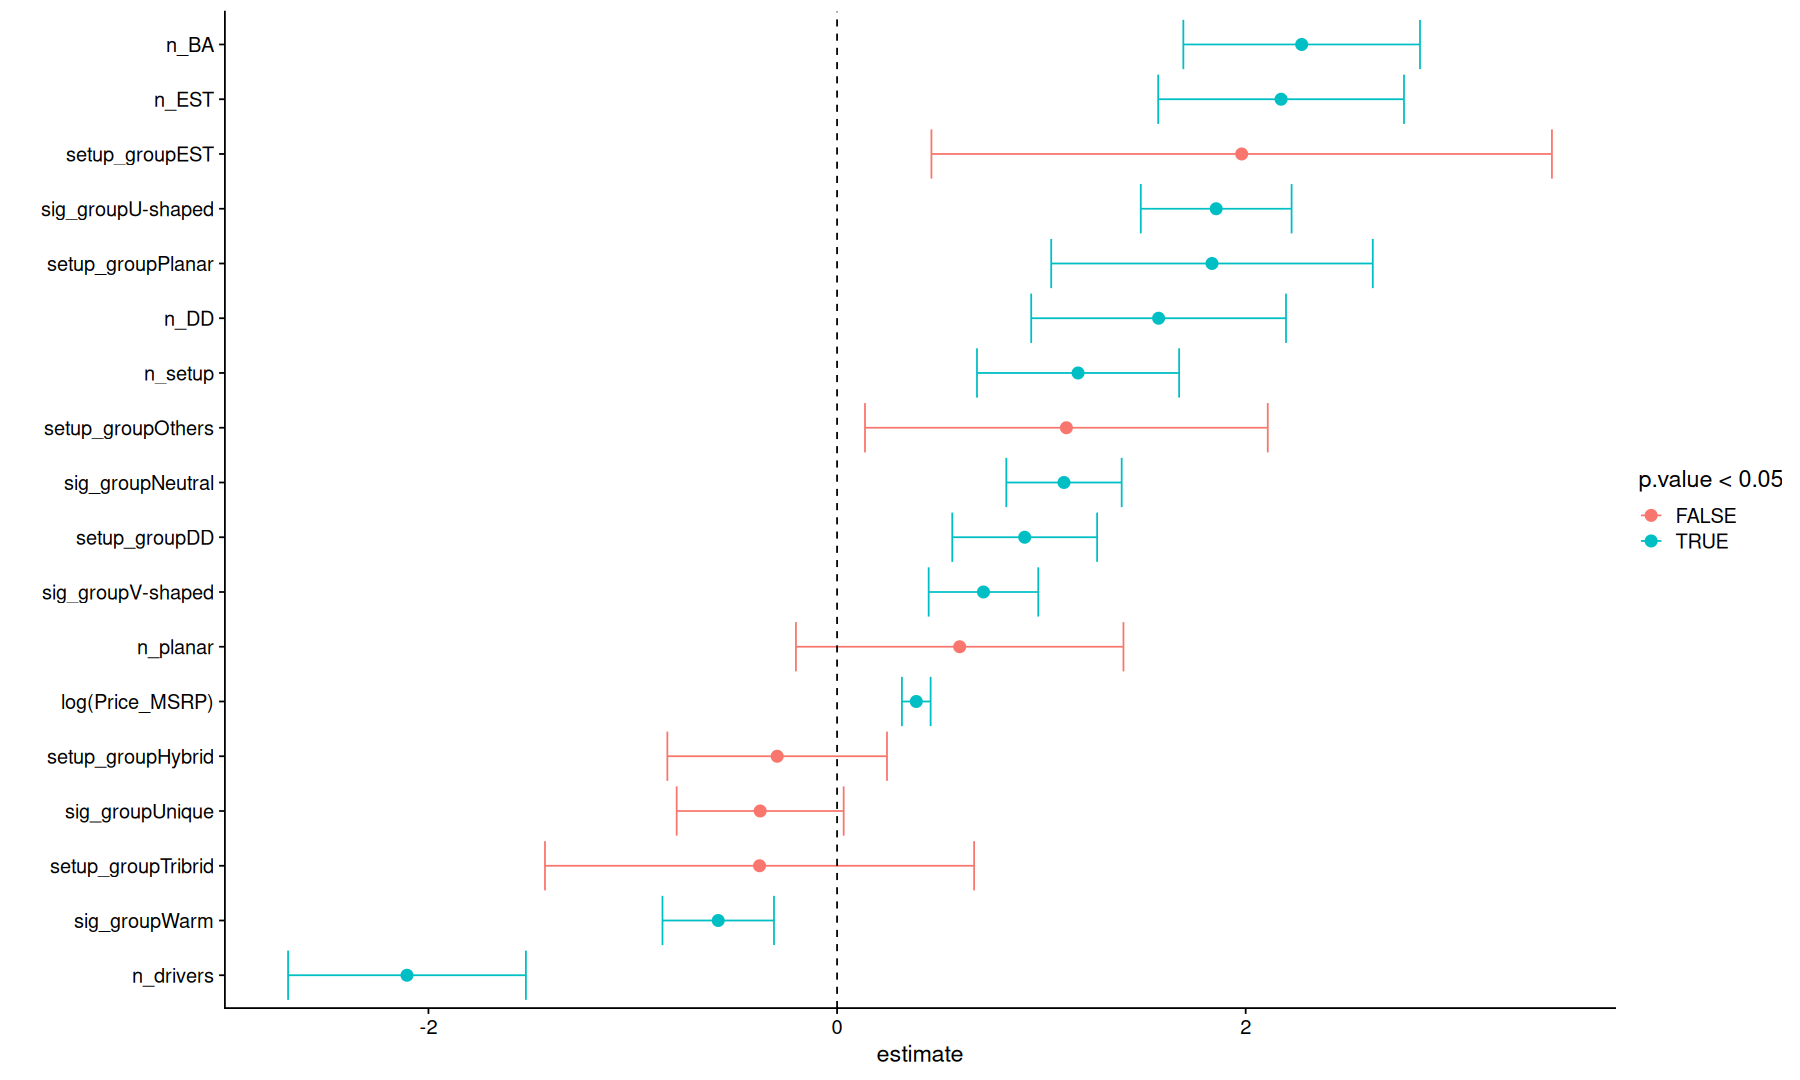

In [16]:
tidy(m) |> 
filter(term!='(Intercept)') |>
ggplot(aes(x=estimate, y=fct_reorder(term, estimate), color=p.value<0.05)) + 
geom_point(size=3) +
geom_errorbar(aes(xmin=estimate-std.error, xmax=estimate+std.error)) +
geom_vline(xintercept=0, linetype=2) +
labs(y='')

the number of BA, EST, and DD drivers was associated with better ranking but the number of planar drivers did not affect the prediction.

the number of distinct drivers had a positive effect while the total number of drivers was associated with a worst ranking.

Neutral, U-shaped, and V-shaped signatures were associated with better rank while Warm signatures were associated with worse rank.

among different setup groups, Planar, EST, and DD had a positive effect.

price had a small but significant positive effect on ranking.

note however that these interpretations are only valid when the model is utilizing all these variables together, 
the interpretation could change if we were to add or remove some of these variables.